In [1]:
import pandas as pd
import keras as keras
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
import glob
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.preprocessing import MinMaxScaler


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cd '/content/drive/MyDrive/OKN/Master IA/Master IA/TFM/mindwave/FASE3' && pwd
# prefix= '/drive/MyDrive/OKN/Master IA/Master IA/TFM/mindwave/FASE3'


Mounted at /content/drive
/content/drive/MyDrive/OKN/Master IA/Master IA/TFM/mindwave/FASE3


In [2]:
import glob
!git clone https://github.com/javierrca/eegcom.git


Cloning into 'eegcom'...
remote: Enumerating objects: 1666, done.
remote: Counting objects: 100% (1666/1666), done.
remote: Compressing objects: 100% (1549/1549), done.
remote: Total 1666 (delta 87), reused 1658 (delta 82), pack-reused 0
Receiving objects: 100% (1666/1666), 14.12 MiB | 8.59 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Filtering content: 100% (11/11), 1.40 GiB | 39.49 MiB/s, done.


In [ ]:
ds_path = "/content/eegcom/dataset"
person_code = "01"
base_path = ds_path + "/" + person_code
print('\nNamed with wildcard *:')
paths=[]
for name in glob.glob(base_path+'/*',recursive = True):
  paths.append(name+"/")

print(paths)

!cd paths[0] && ls -l

# Preparación del dataset EEGPOW

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


def getEegPower(paths):
    dfRaw = []
    X_emot_train = []
    y_emot_train =[]
    filter=[]
    filterLastRows = 2
    i=0
    # print (paths)
    for path in paths:
        dfHead = pd.read_csv(path + 'head.csv')
        all_emot_files = glob.glob(os.path.join(path , "*EEGPOW*.csv"))
        # print(dfHead[dfHead['questionCode']==24].iloc[0]['response'])

        for filename in all_emot_files:
            dfRaw = pd.read_csv(filename, index_col=None, header=0, delimiter=',')
            if len(dfRaw)>=filterLastRows:
                qCode = dfRaw['questionCode'].iloc[[0]][0]
                X_emot_train.append([])
                X = np.array(dfRaw.tail(filterLastRows))
                scaler = MinMaxScaler()
                # transform data
                X = X[:,5:]
                for idx, it in enumerate(X):
                    X_emot_train[i].append([])
                    X_emot_train[i][idx] =X[idx][:]

                y_emot_train.append([])
                y_emot_train[i].append([])
                y_emot_train[i][0] = dfHead[dfHead['questionCode']==qCode].iloc[0]['response']
                i=i+1
    return X_emot_train,y_emot_train


def show_results(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test,pred_y)
    plt.figure(figsize=(5,5))
    labels = ['0: No', '1: Si']
    sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt='d')
    plt.title('Confusion matrix')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print(classification_report(y_test,pred_y))



In [8]:
X_emot_train = []
y_emot_train =[]
X_emot_train,y_emot_train= getEegPower(paths)
X = np.array(X_emot_train)
y = np.array(y_emot_train)
X.shape, y.shape


((225, 2, 10), (225, 1))

In [10]:
!pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=8826bfffacf16f54449b9ac91d727f66d4844d1564b0ceacf21149df57a82bc7
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


In [14]:
X = np.asarray(X).astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.1) # 0.25 x 0.8 = 0.2

y_val_cat =keras.utils.to_categorical(y_val,2)
y_train_cat =keras.utils.to_categorical(y_train,2)
y_test_cat =keras.utils.to_categorical(y_test,2)

X_train.shape, y_train.shape,X_test.shape,y_test.shape,X_val.shape, y_val.shape

((162, 2, 10), (162, 1), (45, 2, 10), (45, 1), (18, 2, 10), (18, 1))

# Modelos

In [19]:
# Modelo EEGPOW/LSTM
from keras.layers import Conv2D, LeakyReLU
from keras.utils import plot_model


keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = keras.Sequential()

input_shape=(X_train.shape[1],X_train.shape[2])

model.add(LSTM(64, return_sequences=True,input_shape=input_shape))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(LSTM(64, input_shape=input_shape))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(Dense(2, activation='sigmoid'))
model.summary()


opt = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

#plot model
# plot_model(model, 'net.png', show_shapes=True,rankdir='LR')
# plot_model(model, 'net.png', show_shapes=True,show_layer_names=False,show_layer_activations=True)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 64)             19200     
                                                                 
 batch_normalization (Batch  (None, 2, 64)             256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 2, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

Epoch 1/200
11/11 [==============================] - 5s 85ms/step - loss: 0.9437 - accuracy: 0.5988 - val_loss: 0.6678 - val_accuracy: 0.5556
Epoch 2/200
11/11 [==============================] - 0s 12ms/step - loss: 0.8812 - accuracy: 0.5741 - val_loss: 0.6677 - val_accuracy: 0.5556
Epoch 3/200
11/11 [==============================] - 0s 10ms/step - loss: 0.8342 - accuracy: 0.5617 - val_loss: 0.6664 - val_accuracy: 0.6111
Epoch 4/200
11/11 [==============================] - 0s 11ms/step - loss: 0.6638 - accuracy: 0.6481 - val_loss: 0.6721 - val_accuracy: 0.6111
Epoch 5/200
11/11 [==============================] - 0s 10ms/step - loss: 0.6664 - accuracy: 0.6667 - val_loss: 0.6637 - val_accuracy: 0.6111
Epoch 6/200
11/11 [==============================] - 0s 12ms/step - loss: 0.6344 - accuracy: 0.6728 - val_loss: 0.6708 - val_accuracy: 0.6111
Epoch 7/200
11/11 [==============================] - 0s 10ms/step - loss: 0.5881 - accuracy: 0.7222 - val_loss: 0.6604 - val_accuracy: 0.7222
Epoch 

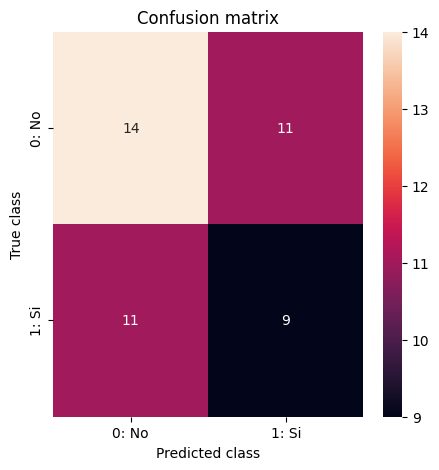

              precision    recall  f1-score   support

           0       0.56      0.56      0.56        25
           1       0.45      0.45      0.45        20

    accuracy                           0.51        45
   macro avg       0.51      0.51      0.51        45
weighted avg       0.51      0.51      0.51        45



In [20]:
class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')> 0.6 and logs.get('accuracy')> 0.8):
              print("\nAlcanzado el 85% de precisión, se cancela el entrenamiento!!")
              self.model.stop_training = True
callbacks1 =myCallback()

history = model.fit(X_train, np.array(y_train_cat), epochs=200, batch_size=16,  validation_data=(X_val, y_val_cat), shuffle=True, callbacks=[callbacks1])

x_test = np.asarray(X_test).astype(np.float32)
y_test_pred = model.predict(x_test)
y_test_pred2 = [np.argmax(i) for i in y_test_pred]
show_results(y_test,y_test_pred2)


In [40]:
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC

def get_flat(X1,Y1):
    x_flat =[]
    y_flat =[]
    for idx, itx in enumerate(X1):
        x = []
        for idy, ity in enumerate(X1[idx]):
            for idz, itz in enumerate(X1[idx][idy]):
                x.append(itz)

        x_flat.append(x)
        y_flat.append(Y1[idx])

    x_flat = pd.DataFrame(x_flat)
    scaler = StandardScaler()
    x_flat = DataFrame(scaler.fit_transform(x_flat))
    y_flat = pd.DataFrame(y_flat)
    return x_flat,y_flat





0.4444444444444444
0.5


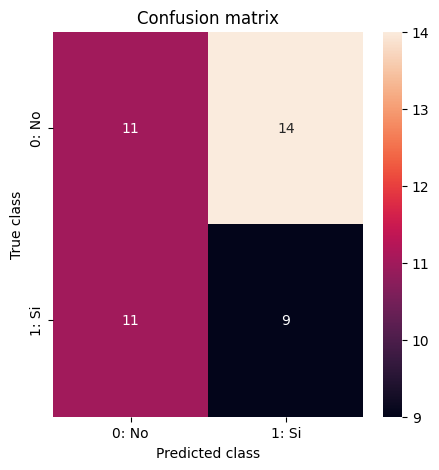

              precision    recall  f1-score   support

           0       0.50      0.44      0.47        25
           1       0.39      0.45      0.42        20

    accuracy                           0.44        45
   macro avg       0.45      0.45      0.44        45
weighted avg       0.45      0.44      0.45        45



In [39]:

# model_svc = SVC(C=0.1, kernel='rbf', gamma='scale')
# model_svc = SVC(C=1, kernel='linear')
# model_svc = SVC(gamma=0.5)
model_svc = SVC(C=200, kernel='sigmoid') #jav 55


model_svc.fit(X_train_flat, y_train_flat)

score = model_svc.score(X_test_flat, y_test_flat)
print(score)

score = model_svc.score(X_val_flat, y_val_flat)
print(score)

pred = model_svc.predict(X_test_flat)
show_results(y_test_flat,pred)


# Analisis

In [ ]:

def get_flat_no_norm(X1,Y1):
    x_flat =[]
    y_flat =[]
    for idx, itx in enumerate(X1):
        x = []
        for idy, ity in enumerate(X1[idx]):
            for idz, itz in enumerate(X1[idx][idy]):
                x.append(itz)

        x_flat.append(x)
        y_flat.append(Y1[idx])

    x_flat = pd.DataFrame(x_flat)
    y_flat = pd.DataFrame(y_flat)
    return x_flat,y_flat

X_train_flat,y_train_flat = get_flat(X_train,y_train)


X_test_flat, y_test_flat = get_flat(X_test,y_test)
X_val_flat, y_val_flat = get_flat(X_val,y_val)
X.shape, X_train_flat.shape ,y_train_flat.shape

print(X_train_flat.shape)
print(y_train_flat.shape)

(162, 21)


<Axes: >

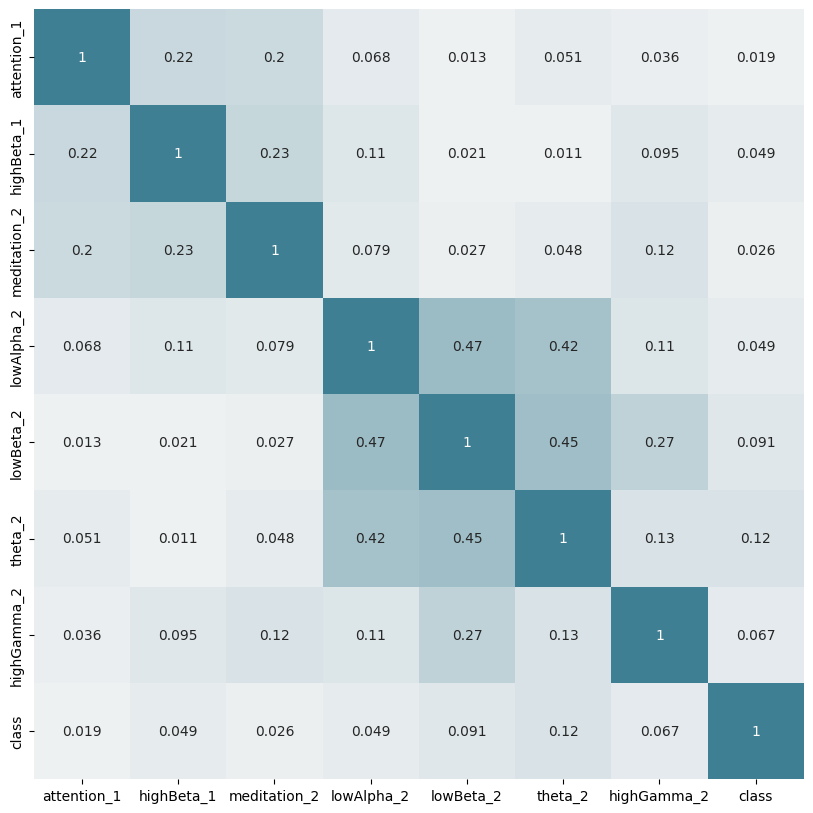

In [37]:
# Analisis Correlación

datos_corr_x_flat,datos_corr_y_flat = get_flat_no_norm(X_train,y_train)

datos = np.append(datos_corr_x_flat,datos_corr_y_flat, axis=1)

print(datos.shape)
datos = pd.DataFrame(datos)
datos.columns = ["attention_1","meditation_1","lowGamma_1","highGamma_1","highAlpha_1","delta_1","highBeta_1","lowAlpha_1","lowBeta_1","theta_1","attention_2","meditation_2","lowGamma_2","highGamma_2","highAlpha_2","delta_2","highBeta_2","lowAlpha_2","lowBeta_2","theta_2","class"]

pd.set_option('display.max_rows', 500)

# datos = datos.filter(items=["meditation_1","attention_1","highBeta_1","meditation_2","lowAlpha_2","lowBeta_2","highAlpha_2","theta_2","highGamma_2","class"])
datos = datos.filter(items=["attention_1","highBeta_1","meditation_2","lowAlpha_2","lowBeta_2","theta_2","highGamma_2","class"])

datos = datos.select_dtypes(include=['float64', 'int'])
corr_matrix = datos.corr(method='pearson').abs()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 10},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)



In [ ]:
from joblib import dump, load
# dump(model_svc, 'model_svc.svc')
# model_svc.save('model_svc2.svc')
# model_svc = load('model_svc.svc')
# model.save('model_01.keras')
# model = keras.models.load_model('model_01.keras')


1/1 [==============================] - 0s 64ms/step


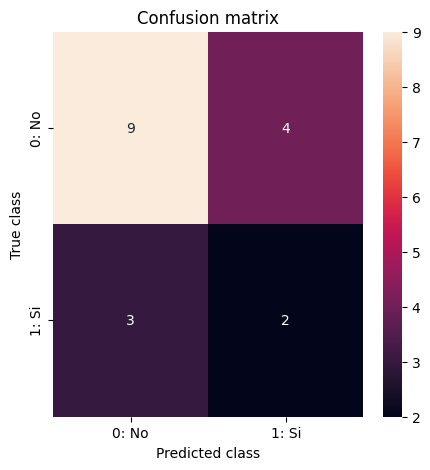

              precision    recall  f1-score   support

           0       0.75      0.69      0.72        13
           1       0.33      0.40      0.36         5

    accuracy                           0.61        18
   macro avg       0.54      0.55      0.54        18
weighted avg       0.63      0.61      0.62        18



In [23]:
y_pred = model.predict(X_val)
y_pred2 = [np.argmax(i) for i in y_pred]
y_val2=  [np.argmax(i) for i in y_val_cat]


show_results(y_val,y_pred2)

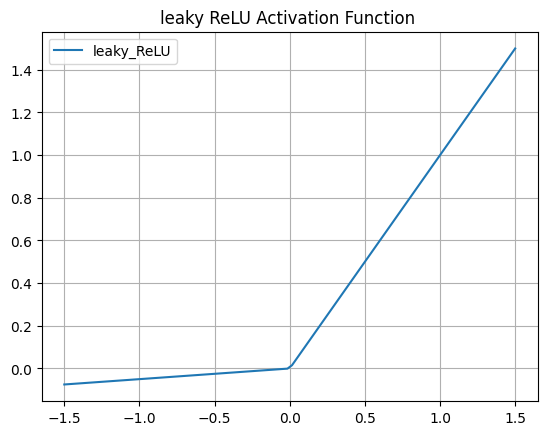

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Leaky Rectified Linear Unit (leaky ReLU) Activation Function
def leaky_ReLU(x):
  data = [max(0.05*value,value) for value in x]
  return np.array(data, dtype=float)

# Derivative for leaky ReLU
def der_leaky_ReLU(x):
  data = [1 if value>0 else 0.05 for value in x]
  return np.array(data, dtype=float)

# Generating data For Graph
x_data = np.linspace(-1.5,1.5,100)
y_data = leaky_ReLU(x_data)
dy_data = der_leaky_ReLU(x_data)

# Graph
plt.plot(x_data, y_data)
plt.title('leaky ReLU Activation Function ')
plt.legend(['leaky_ReLU'])
plt.grid()
plt.show()